In [1]:
# import required libraries
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import re
import csv
from collections import OrderedDict
import numpy as np

In [2]:
# THINGS TO DO
# identify scale for loan balance data
# Filter out non-US cost of living data

In [3]:
# import data containing mean income for each age in 2019
mean_income = pd.read_csv('data/mean-income-by-age-2019.csv')
mean_income.columns = ['age', 'mean_income']
mean_income.head(2)

# remove price formating and convert object type to float
mean_income['mean_income'] = mean_income['mean_income'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)

mean_income.head(2)

,age,mean_income
0,18,8419.92
1,19,13484.63


In [4]:
# import data containing median income for each age in 2019
median_income = pd.read_csv('data/median-income-by-age-2019.csv')
median_income.columns = ['age', 'median_income']

#remove price formatting and convert object type to float
median_income['median_income'] = median_income['median_income'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
median_income.head(2)

,age,median_income
0,18,5000.0
1,19,10000.0


In [5]:
# merge median and mean income to single df
income_by_age = pd.merge(median_income, mean_income)
income_by_age.head()

,age,median_income,mean_income
0,18,5000.0,8419.92
1,19,10000.0,13484.63
2,20,14438.0,17456.99
3,21,18000.0,21927.80
4,22,18501.0,23680.10


In [6]:
#import amount of debt distributed with a context manager

# open file with a context manager
with open('data/debt_amt_distribution2014.csv') as file:
    reader = csv.DictReader(file)
    borrowers = OrderedDict()
    
    # store names for columns
    cols=reader.fieldnames
    
    # loop through rows of file
    for i, row in enumerate(reader):
        
        # use RegEx to extract start and stop of balance range as ints
        loan_bal = str(row[cols[0]])
        bal_range = re.findall(r'\d+', loan_bal)
        map(int, bal_range)
        
        # remove comma formatting in numbers
        num_bor = str(row[cols[1]])
        num_bor = int(num_bor.replace(',', ''))
        
        # append entry to OrderedDict
        borrowers[i] = [loan_bal, num_bor, bal_range[0], bal_range[-1]]
    
# convert dict to DataFrame and format columns
borrowers = pd.DataFrame(borrowers)
borrowers = borrowers.transpose()
borrowers.columns = cols + ['minBal', 'maxBal']

# Set extremes of ranges to NaN
borrowers.minBal[0] = np.nan
borrowers.maxBal[8] = np.nan

# compute total borrowers and percentage of borrowers by group
borrowers['percentage'] = (borrowers.NumberOfBorrowers/sum(borrowers.NumberOfBorrowers))
borrowers = borrowers.round({'percentage': 3})

# final version of the 2014 borrowers DataFrame
borrowers_2014 = borrowers.copy()

borrowers_2014

,Balance2014,NumberOfBorrowers,minBal,maxBal,percentage
0,<$5001,9028800,NaN,5001,0.20831
1,betw $5000 and $10000,7785500,5000,10000,0.179625
2,betw $10000 and $25000,12348000,10000,25000,0.28489
3,betw $25000 and $50000,7997000,25000,50000,0.184505
4,betw $50000 and $75000,3126800,50000,75000,0.0721407
5,betw $75000 and $100000,1238100,75000,100000,0.0285651
6,betw $100000 and $150000,1026100,100000,150000,0.0236739
7,betw $150000 and $200000,444200,150000,200000,0.0102485
8,betw $200000+,348600,200000,NaN,0.0080428


In [7]:
# import amount of debt distributed in 2014
borrowers = pd.read_csv('data/debt_amt_distribution2014.csv')

#remove number formatting and convert NumBorrowers to int
borrowers.NumberOfBorrowers = borrowers.NumberOfBorrowers.astype(str).str.replace(',', '').astype(int)

# compute total borrowers and percentage of borrowers by group
borrowers['total'] = sum(borrowers.NumberOfBorrowers)
borrowers['percentage'] = round(borrowers.NumberOfBorrowers / borrowers.total, 3)



In [8]:
# import student load balance by age group
# scale: in billions by age group
loan_balance_by_year = pd.read_csv('data/loan-balance-by-age.csv')
loan_balance_by_year.head(2)

,Year,under30,30_39,40_49,50_59,60+,unknown
0,2004,146.0,114.0,49.2,30.9,6.1,0.9
1,2005,161.0,129.0,55.6,38.3,8.2,0.7


In [9]:
# index loan balance by age with years as columns
loan_balance_by_age = loan_balance_by_year.transpose()

# name columns accordingly and remove row containing years
loan_balance_by_age.columns = [str(int(year))+'LB' for year in loan_balance_by_age.loc['Year']]
loan_balance_by_age = loan_balance_by_age.iloc[1:]

#remove row containing data for unknown age groups
loan_balance_by_age = loan_balance_by_age.iloc[:-1]

# index by head of age group
loan_balance_by_age.index = [18, 30, 40, 50, 60]

#save df to plot data by age group
lb_plot = loan_balance_by_age.copy()

#reindex data for all ages between 18 and 80
loan_balance_by_age['age_group'] = loan_balance_by_age.index
loan_balance_by_age = loan_balance_by_age.reindex(range(18,81,1))

# Forward fill data with values for respective age ranges
loan_balance_by_age = loan_balance_by_age.fillna(method='ffill')
loan_balance_by_age['age'] = loan_balance_by_age.index


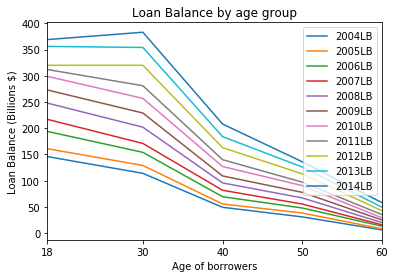

In [10]:
# plot loan balance by age for last 10 years
lb_plot.plot()
plt.xticks([18, 30, 40, 50, 60])
plt.xlabel('Age of borrowers')
plt.ylabel('Loan Balance (Billions $)')
plt.title('Loan Balance by age group')
plt.show()

In [11]:
# JOIN income_by_age with loan_balance_by_age on age column
# create final version of clean dataframe
loan_data = income_by_age.join(loan_balance_by_age,on='age', lsuffix='', rsuffix='_dup')
loan_data = loan_data.drop(axis=1, labels='age_dup')
loan_data = loan_data.sort_index()


In [12]:
# read csv files containing earnings by ocupation for individual years
# each file corresponds to a single year of occupation data (2010-2018)

# create list of dataframes from all files in data folder
filenames = glob('data/earnings-by-occupation/*.csv')
ebo_dfs = []
for f in filenames:
    df = pd.read_csv(f, na_values='(X)')
    df.columns = df.iloc[0]
    df['filename'] = str(f)
    ebo_dfs.append(df)

# concat all dfs in list
earnings_by_ocup = pd.concat(ebo_dfs, sort=True)

# remove all rows indexed with zero that contain column labels
# keep rows indexed with 1 that contain data for individual years
earnings_by_ocup = earnings_by_ocup.loc[1]
earnings_by_ocup = earnings_by_ocup.reset_index()

# extract year from file name string and set as index
earnings_by_ocup['year'] = earnings_by_ocup['filename'].str.slice(35,39)
earnings_by_ocup = earnings_by_ocup.set_index('year')

# use RegEx to identify 'Margin of Error' columns
pattern = re.compile('(?:^|\W)Margin of Error(?:$|\W)')
cols2keep = [not bool(pattern.findall(name)) for name in earnings_by_ocup.columns]

# transpose: rows= occupation data, cols= years of median incom
earnings_by_ocup = earnings_by_ocup.transpose()

# filter out 'ROWS' regarding margin of error
earnings_by_ocup = earnings_by_ocup[cols2keep]

#remove first two rows: column names and country
earnings_by_ocup = earnings_by_ocup.iloc[2:]

#remove last rows: filename, id
earnings_by_ocup = earnings_by_ocup.iloc[:-2]
earnings_by_ocup['ocup'] = earnings_by_ocup.index

#create columns for relevant income data
earnings_by_ocup['ocup'] = earnings_by_ocup['ocup'].astype('str')
earnings_by_ocup['income_type'] = earnings_by_ocup['ocup'].str.split("!!").str[0]
earnings_by_ocup['gender'] = earnings_by_ocup['ocup'].str.split("!!").str[1]
earnings_by_ocup['ocupation'] = earnings_by_ocup['ocup'].str.split("!!").str[4]

# rows with relevant occupation info have Median earnings as income type, and Male or Female as gender
earnings_by_ocup = earnings_by_ocup[earnings_by_ocup['income_type'] == 'Median earnings (dollars)']
earnings_by_ocup = earnings_by_ocup[(earnings_by_ocup['gender'] == 'Male') | (earnings_by_ocup['gender'] == 'Female')]

# Use RegEx to ignore and remove race specific data
race_pattern = re.compile('(?:^|\W)race(?:$|\W)')
rows_without_race = [not bool(race_pattern.findall(str(x))) for x in earnings_by_ocup.ocupation]
earnings_by_ocup = earnings_by_ocup[rows_without_race]
race_pattern = re.compile('(?:^|\W)Race(?:$|\W)')
rows_without_race = [not bool(race_pattern.findall(str(x))) for x in earnings_by_ocup.ocupation]
earnings_by_ocup = earnings_by_ocup[rows_without_race]
race_pattern = re.compile('(?:^|\W)races(?:$|\W)')
rows_without_race = [not bool(race_pattern.findall(str(x))) for x in earnings_by_ocup.ocupation]
earnings_by_ocup = earnings_by_ocup[rows_without_race]

# drop rows where any value is missing
earnings_by_ocup = earnings_by_ocup.dropna(how='any')

# drop redundant column
earnings_by_ocup = earnings_by_ocup.drop(axis=1, labels='ocup')

# Multi-Index by ocupation and gender, sorted by ocupation
earnings_by_ocup = earnings_by_ocup.set_index(['ocupation', 'gender'])
earnings_by_ocup = earnings_by_ocup.sort_index(level=0)

# final version on clean dataframe
ocup_data = earnings_by_ocup.copy()


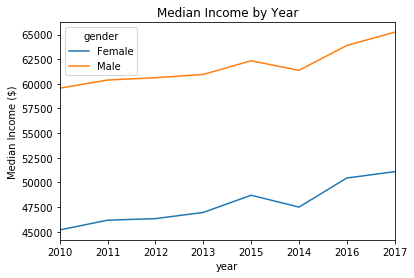

In [13]:
# Plot single occupation to visually inspect results
pa_df = earnings_by_ocup.loc['Public administration']
pa_df = pa_df.drop(axis=1, labels='income_type')
pa_df = pa_df.astype(float)
pa_df = pa_df.transpose()
pa_df.plot()
plt.title('Median Income by Year')
plt.ylabel('Median Income ($)')
plt.show()

In [14]:
# import cost of living dataset
cost_of_living = pd.read_csv('data/cost-of-living-index.csv')

# separate columns for country and city
cost_of_living['country'] = cost_of_living['City'].astype(str).str.split(',').str[1]
cost_of_living['city'] = cost_of_living['City'].astype(str).str.split(',').str[0]

# convert city and country from object type to string
cost_of_living['country_str'] = cost_of_living.country.apply(lambda x: str(x).split(','))

# Just need City, Cost Of Living Index, and Rank
cost_of_living = cost_of_living[['country','city', 'Cost of Living Index', 'Rank']]
cost_of_living.columns = ['country', 'city', 'cost_of_living', 'rank']


#### FIX ME
# Filter data not related to United States
#cost_of_living = cost_of_living[cost_of_living['country'].astype(str).str=='United States']
#cost_of_living['country']

In [15]:
# inspect final datasets

In [16]:
cost_of_living.head()

,country,city,cost_of_living,rank
0,Bermuda,Hamilton,137.56,1
1,Switzerland,Zurich,128.65,2
2,Switzerland,Basel,126.89,3
3,Switzerland,Lausanne,119.62,4
4,Switzerland,Bern,118.42,5


In [17]:
borrowers_2014.head()

,Balance2014,NumberOfBorrowers,minBal,maxBal,percentage
0,<$5001,9028800,NaN,5001,0.20831
1,betw $5000 and $10000,7785500,5000,10000,0.179625
2,betw $10000 and $25000,12348000,10000,25000,0.28489
3,betw $25000 and $50000,7997000,25000,50000,0.184505
4,betw $50000 and $75000,3126800,50000,75000,0.0721407


In [18]:
loan_data.head()

,age,median_income,mean_income,2004LB,2005LB,2006LB,2007LB,2008LB,2009LB,2010LB,2011LB,2012LB,2013LB,2014LB,age_group
0,18,5000.0,8419.92,146.0,161.0,194.0,217.0,248.0,273.0,299.0,312.0,320.0,356.0,369.0,18.0
1,19,10000.0,13484.63,146.0,161.0,194.0,217.0,248.0,273.0,299.0,312.0,320.0,356.0,369.0,18.0
2,20,14438.0,17456.99,146.0,161.0,194.0,217.0,248.0,273.0,299.0,312.0,320.0,356.0,369.0,18.0
3,21,18000.0,21927.80,146.0,161.0,194.0,217.0,248.0,273.0,299.0,312.0,320.0,356.0,369.0,18.0
4,22,18501.0,23680.10,146.0,161.0,194.0,217.0,248.0,273.0,299.0,312.0,320.0,356.0,369.0,18.0


In [19]:
ocup_data.head()

year                                                        2010   2011  \
ocupation                                          gender                 
Accommodation and food services                    Female  20867  21190   
                                                   Male    25350  25388   
Administrative and support and waste management... Female  29972  30211   
                                                   Male    32226  32121   
Agriculture, forestry, fishing and hunting         Female  24020  24889   

year                                                        2012   2013  \
ocupation                                          gender                 
Accommodation and food services                    Female  21276  21737   
                                                   Male    25572  25900   
Administrative and support and waste management... Female  30359  30407   
                                                   Male    32376  32144   
Agriculture, forestry, fishing and hunting         Female  23657  23017   

year                                                        2015   2014  \
ocupation                                          gender                 
Accommodation and food services                    Female  22392  21932   
                                                   Male    26785  26422   
Administrative and support and waste management... Female  30626  30402   
                                                   Male    33653  32417   
Agriculture, forestry, fishing and hunting         Female  25302  23854   

year                                                        2016   2017  \
ocupation                                          gender                 
Accommodation and food services                    Female  23076  24328   
                                                   Male    28026  29530   
Administrative and support and waste management... Female  31279  31870   
                                                   Male    34709  36582   
Agriculture, forestry, fishing and hunting         Female  25860  26551   

year                                                                     income_type  
ocupation                                          gender                             
Accommodation and food services                    Female  Median earnings (dollars)  
                                                   Male    Median earnings (dollars)  
Administrative and support and waste management... Female  Median earnings (dollars)  
                                                   Male    Median earnings (dollars)  
Agriculture, forestry, fishing and hunting         Female  Median earnings (dollars)

In [20]:
# write clean_data to csv files
export_loan = loan_data.to_csv('clean_data/loan_data.csv', header=True)
export_loan

In [21]:
export_ocup = ocup_data.to_csv('clean_data/ocup_data.csv', header=True)
export_ocup

In [22]:
export_borrowers = borrowers_2014.to_csv('clean_data/borrowers_2014.csv', header=True)
export_borrowers

In [23]:
export_col = cost_of_living.to_csv('clean_data/cost_of_living.csv')
export_col